# Mediapipe

0 - nose
1 - left eye (inner)
2 - left eye
3 - left eye (outer)
4 - right eye (inner)
5 - right eye
6 - right eye (outer)
7 - left ear
8 - right ear
9 - mouth (left)
10 - mouth (right)
11 - left shoulder
12 - right shoulder
13 - left elbow
14 - right elbow
15 - left wrist
16 - right wrist
17 - left pinky
18 - right pinky
19 - left index
20 - right index
21 - left thumb
22 - right thumb
23 - left hip
24 - right hip
25 - left knee
26 - right knee
27 - left ankle
28 - right ankle
29 - left heel
30 - right heel
31 - left foot index
32 - right foot index


In [15]:
import cv2
import mediapipe as mp
import numpy as np
import time 
import pyrealsense2 as rs
import math as m
import matplotlib.pyplot as plt

In [3]:
pos_dict = {"nose":0,
"left eye (inner)":1,
"left eye":2,
"left eye (outer)":3,
"right eye (inner)":4,
"right eye":5,
"right eye (outer)":6,
"left ear":7,
"right ear":8,
"mouth (left)":9,
"mouth (right)":10,
"left shoulder":11,
"right shoulder":12,
"left elbow":13,
"right elbow":14,
"left wrist":15,
"right wrist":16,
"left pinky":17,
"right pinky":18,
"left index":19,
"right index":20,
"left thumb":21,
"right thumb":22,
"left hip":23,
"right hip":24,
"left knee":25,
"right knee":26,
"left ankle":27,
"right ankle":28,
"left heel":29,
"right heel":30,
"left foot index":31,
"right foot index":32}


In [4]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def compute_angle(shoudler, hip, elbow):
    """ Returns the angle in radiants between of the arm defined by its shoudler, hip and elbow"""
    v1 = unit_vector(np.array(hip) - np.array(shoudler))
    v2 = unit_vector(np.array(elbow) - np.array(shoudler))
    return np.arccos(np.clip(np.dot(v1, v2),-1.0,1.0))*360/(2*np.pi)

def compute_arms_angle(prediction):
    """ Returns the angle of left and right arm wrt to the torso (return nan if the arm is not seen) """
    
    keypoints = prediction

    # left arm
    left_shoulder = [keypoints[pos_dict["left shoulder"]].x, keypoints[pos_dict["left shoulder"]].y]
    left_hip = [keypoints[pos_dict["left hip"]].x, keypoints[pos_dict["left hip"]].y]
    left_elbow = [keypoints[pos_dict["left elbow"]].x, keypoints[pos_dict["left elbow"]].y]

    # right arm
    right_shoulder = [keypoints[pos_dict["right shoulder"]].x, keypoints[pos_dict["right shoulder"]].y]
    right_hip = [keypoints[pos_dict["right hip"]].x, keypoints[pos_dict["right hip"]].y]
    right_elbow = [keypoints[pos_dict["right elbow"]].x, keypoints[pos_dict["right elbow"]].y]

    print(f"left_shoudler: {left_shoulder}")
    print(f"right_shoulder: {right_shoulder}")

    return(compute_angle(left_shoulder, left_hip, left_elbow), compute_angle(right_shoulder, right_hip, right_elbow))

def angles_to_command(left_angle, right_angle):
    """Returns the command corresponding to arms angle"""
    
    up_angle = 160
    horizontal_angle = 90
    down_angle = 20
    margin = 15

    # backward angle = 160 +/- 10
    if (left_angle > up_angle-margin and left_angle < up_angle+margin) and (right_angle > up_angle-margin and right_angle < up_angle+margin):
        return "backward"
    # forward angle = 90 +/- 10
    if (left_angle > horizontal_angle-margin and left_angle < horizontal_angle+margin) and (right_angle > horizontal_angle-margin and right_angle < horizontal_angle+margin):
        return "forward"
    # left = left: 90 +/- 10 right: 20 +/- 10
    if (left_angle > horizontal_angle-margin and left_angle < horizontal_angle+margin) and (right_angle > down_angle-margin and right_angle < down_angle+margin):
        return "left"
    # right = left: 20 +/- 10 right: 90 +/- 10
    if (left_angle > down_angle-margin and left_angle < down_angle+margin) and (right_angle > horizontal_angle-margin and right_angle < horizontal_angle+margin):
        return "right"
    else:
        return "stop"

In [5]:
img_size = [480,640]

## Using the webcam

In [9]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

new_frame_time = 0
prev_frame_time = 0

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    # compute the commands based on the angles of the arms at the shoulder
    left_angle, right_angle = compute_arms_angle(results.pose_landmarks.landmark)
    command = angles_to_command(left_angle, right_angle)
    print(command)

    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Flip the image horizontally for a selfie-view display.
    fps = str(int(fps))
    image = cv2.flip(image,1)
    cv2.putText(image, fps, (7, 70), 1, 3, (100, 255, 0), 3, cv2.LINE_AA)
    cv2.imshow('MediaPipe Pose', image)
    c = cv2.waitKey(1)
    if c == 27: # press escape to quit
        break
cap.release()

left_shoudler: [0.89393150806427, 0.8470526933670044]
right_shoulder: [0.26198890805244446, 0.8584014177322388]
stop
left_shoudler: [0.8942190408706665, 0.8460826277732849]
right_shoulder: [0.2626146674156189, 0.8738288283348083]
stop
left_shoudler: [0.8950250744819641, 0.843911349773407]
right_shoulder: [0.2625727653503418, 0.8798515796661377]
stop
left_shoudler: [0.8955814242362976, 0.8438328504562378]
right_shoulder: [0.2620868980884552, 0.8833890557289124]
stop
left_shoudler: [0.8975224494934082, 0.8438959121704102]
right_shoulder: [0.26265034079551697, 0.8830762505531311]
stop
left_shoudler: [0.8985487222671509, 0.8429775238037109]
right_shoulder: [0.26326125860214233, 0.8826800584793091]
stop
left_shoudler: [0.8991727828979492, 0.8429161310195923]
right_shoulder: [0.2633482813835144, 0.8828815221786499]
stop
left_shoudler: [0.8995195627212524, 0.8422285318374634]
right_shoulder: [0.2633183002471924, 0.88273024559021]
stop
left_shoudler: [0.9003909230232239, 0.8416522741317749]
ri

## Using intel realsense

In [6]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def cart2sph(x,y,z):
    XsqPlusYsq = x**2 + y**2
    r = m.sqrt(XsqPlusYsq + z**2)               # r
    elev = m.atan2(z,m.sqrt(XsqPlusYsq))     # theta
    az = m.atan2(y,x)                           # phi
    return r, elev, az

def rad2deg(rad):
    return rad*180/m.pi

In [16]:

DETECTION = True
BASE_ORIENTATION = [0, 0, -1]

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

new_frame_time = 0
prev_frame_time = 0

# Configure the RealSense pipeline
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.gyro)
config.enable_stream(rs.stream.accel)

# Initialize the RealSense pipeline
cfg = pipeline.start(config)
colorizer = rs.colorizer()

profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intr = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics

fps_history = []

with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    while True:
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames() # depth, rgb, accel, gyro

        accel_frame = frames[2]
        gyro_frame = frames[3]

        if gyro_frame:
            gyro_data = gyro_frame.as_motion_frame().get_motion_data()

        if accel_frame:
            accel_data = accel_frame.as_motion_frame().get_motion_data()
            orientation = [accel_data.x, accel_data.y, accel_data.z]
            orientation[1], orientation[2] = orientation[2], orientation[1] #swap y and z
            rotation = rotation_matrix_from_vectors(orientation, BASE_ORIENTATION) # rotation required to be aligned with gravity

        # Create alignment primitive with color as its target stream:
        align = rs.align(rs.stream.color)
        frameset = align.process(frames)

        # get aligned frames
        depth_frame = frameset.get_depth_frame()
        color_frame = frameset.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())


        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time
       
        
        # ==== OPENPIFPAF =====
        if DETECTION:
            # img = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
            color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
            results = pose.process(color_image)
            frame = color_image

            left_angle, right_angle = compute_arms_angle(results.pose_landmarks.landmark)
            command = angles_to_command(left_angle, right_angle)
            print(command)

            try:
                # keypoints
                keypoints = results.pose_landmarks.landmark

                img_width = 640
                img_height = 480

                # right arm
                right_elbow = [keypoints[pos_dict["right elbow"]].x*img_width, keypoints[pos_dict["right elbow"]].y*img_height]
                right_wrist = [keypoints[pos_dict["right wrist"]].x*img_width, keypoints[pos_dict["right wrist"]].y*img_height]

                # get 3d coordinates of the right elbow and wrist
                right_elbow_3d = rs.rs2_deproject_pixel_to_point(intr, right_elbow, depth_frame.get_distance(int(right_elbow[0]), int(right_elbow[1])))
                right_wrist_3d = rs.rs2_deproject_pixel_to_point(intr, right_wrist, depth_frame.get_distance(int(right_wrist[0]), int(right_wrist[1])))

                # compute vector from elbow to wrist
                right_forearm_vector = np.array(right_wrist_3d) - np.array(right_elbow_3d)
                
                # coorect vector orientation
                right_forearm_vector[[1,2]] = right_forearm_vector[[2,1]] # swap y and z
                corrected_forearm_vector = rotation.dot(right_forearm_vector) # rotate forearm vector to align with gravity
                corrected_forearm_vector[2] = -corrected_forearm_vector[2] # invert z to have positive elevation when arm is raised

                # convert to spherical coordinates
                _, elevation, azimuth = cart2sph(*corrected_forearm_vector)
                elevation = rad2deg(elevation)
                azimuth = rad2deg(azimuth)

                print(f"azimuth: {azimuth}, elevation: {elevation}")

            except:
                print("issue with keypoint detection (missing eypoints/no person detected)")
                pass
            mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            frame = cv2.flip(frame,1)
            fps_history.append(fps)
            fps = str(int(fps))
            cv2.putText(frame, fps, (7, 70), 1, 3, (100, 255, 0), 3, cv2.LINE_AA)
            cv2.imshow('MediaPipe Pose', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
            c = cv2.waitKey(1)
            if c == 27: # press escape to quit
                break
        # ==== END OPENPIFPAF =====

left_shoudler: [0.7867443561553955, 0.6125069856643677]
right_shoulder: [0.4960276186466217, 0.5430164933204651]
left
azimuth: 0.0, elevation: -0.0
left_shoudler: [0.7863443493843079, 0.6112421154975891]
right_shoulder: [0.49603381752967834, 0.5462877154350281]
left
azimuth: 0.0, elevation: -0.0
left_shoudler: [0.7867050170898438, 0.6103769540786743]
right_shoulder: [0.496347576379776, 0.5488464832305908]
left
azimuth: 0.0, elevation: -0.0
left_shoudler: [0.7944251298904419, 0.6052076816558838]
right_shoulder: [0.4973921775817871, 0.5487902164459229]
left
azimuth: 0.0, elevation: -0.0
left_shoudler: [0.7935693860054016, 0.6065489649772644]
right_shoulder: [0.4976041913032532, 0.5518935322761536]
left
azimuth: 0.0, elevation: -0.0
left_shoudler: [0.7912579774856567, 0.6065901517868042]
right_shoulder: [0.49853992462158203, 0.5551138520240784]
left
azimuth: 0.0, elevation: -0.0
left_shoudler: [0.7848966121673584, 0.606909453868866]
right_shoulder: [0.49814826250076294, 0.5599419474601746

In [1]:
pipeline.stop()

NameError: name 'pipeline' is not defined

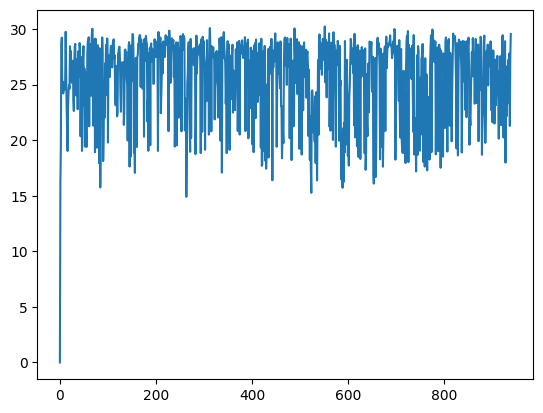

: 

In [17]:
plt.plot(fps_history)

In [27]:
results.pose_landmarks.landmark[0]

x: 0.5413907766342163
y: 0.695400595664978
z: -1.8571964502334595
visibility: 0.9998742341995239